In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from numpy import array
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from numpy import asarray
from numpy import zeros
import keras

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv(r'/content/drive/MyDrive/MSc Project/Data/MergedDataset.csv')

In [5]:
df.head()

,text,label
0,flynn hillary clinton big woman campus breitba...,0
1,jackie mason hollywood would love trump bombed...,0
2,benot hamon wins french socialist partys presi...,0
3,excerpts draft script donald trumps qampa blac...,0
4,backchannel plan ukraine russia courtesy trump...,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


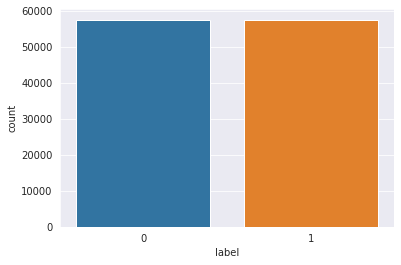

In [6]:
import seaborn as sns
sns.set_style("darkgrid")
sns.countplot(df.label)

In [7]:
len(df.index)

115144

In [8]:
X = df['text']
y = df['label']

In [9]:
print(len(X))
print(len(y))

115144
115144


In [10]:
test_size = 0.1
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True)

In [11]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

103629
103629
11515
11515


In [12]:
tokenizer = Tokenizer()

#preparing vocabulary
tokenizer.fit_on_texts(X_train)

#converting text into integer sequences
X_train_seq  = tokenizer.texts_to_sequences(X_train) 
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [13]:
vocab_length = len(tokenizer.word_index) + 1
vocab_length

374860

In [14]:
print(X_train[0])
print(X_train_seq[0])

flynn hillary clinton big woman campus breitbart ever get feeling life circles roundabout rather heads straight line toward intended destination hillary clinton remains big woman campus leafy liberal wellesley massachusetts everywhere else votes likely inauguration dress remainder days way miss havisham forever wore wedding dress speaking great expectations hillary rodham overflowed years ago first addressed wellesley graduating class president college informed gathered students needed debate far could ascertain spokesman kind like democratic primaries minus terms unknown even seven sisters school glad miss adams made clear speaking today us us miss rodham told classmates appointing edger bergen charlie mccarthys mortimer snerds attendance bespectacled granny glasses awarding matronly wisdom least john lennon wisdom took issue previous speaker despite becoming first win election seat u senate since reconstruction edward brooke came criticism calling empathy goals protestors criticized 

In [15]:
embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/MSc Project/glove.6B.100d.txt', encoding="utf8")

In [16]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [17]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [18]:
maxlen = 500

In [19]:
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

In [20]:
training_padded = np.array(X_train_pad)
training_labels = np.array(y_train)
testing_padded = np.array(X_test_pad)
testing_labels = np.array(y_test)

In [21]:
model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

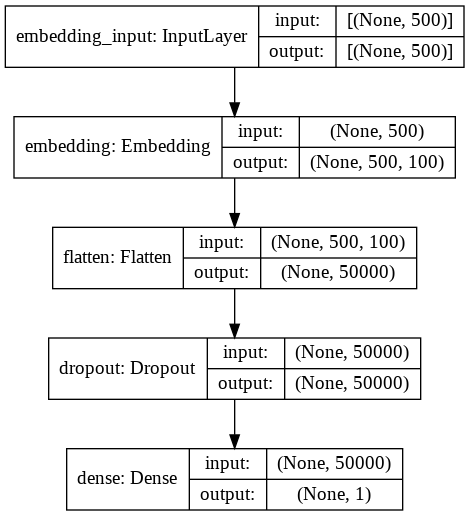

In [22]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [26]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.01,
#     decay_steps=10000,
#     decay_rate=0.9)
# opt = keras.optimizers.SGD(learning_rate=lr_schedule)

opt = keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

#Adding callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)  
mc=ModelCheckpoint('logisticregression_best_model_margeddataset.h5', monitor='val_acc', mode='max', save_best_only=True, verbose=1)

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 100)          37486000  
_________________________________________________________________
flatten (Flatten)            (None, 50000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 50000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 50001     
Total params: 37,536,001
Trainable params: 50,001
Non-trainable params: 37,486,000
_________________________________________________________________
None


In [27]:
history = model.fit(x=training_padded, y=training_labels, epochs=50, verbose=1, validation_data=(testing_padded, testing_labels), callbacks=[es, mc], batch_size=256)

Epoch 1/50
405/405 [==============================] - 15s 30ms/step - loss: 0.5570 - acc: 0.7722 - val_loss: 0.2645 - val_acc: 0.9015

Epoch 00001: val_acc improved from -inf to 0.90152, saving model to logisticregression_best_model_margeddataset.h5
Epoch 2/50
405/405 [==============================] - 12s 30ms/step - loss: 0.2478 - acc: 0.9085 - val_loss: 0.2301 - val_acc: 0.9136

Epoch 00002: val_acc improved from 0.90152 to 0.91359, saving model to logisticregression_best_model_margeddataset.h5
Epoch 3/50
405/405 [==============================] - 12s 29ms/step - loss: 0.2160 - acc: 0.9202 - val_loss: 0.2133 - val_acc: 0.9204

Epoch 00003: val_acc improved from 0.91359 to 0.92036, saving model to logisticregression_best_model_margeddataset.h5
Epoch 4/50
405/405 [==============================] - 12s 29ms/step - loss: 0.1952 - acc: 0.9298 - val_loss: 0.2037 - val_acc: 0.9232

Epoch 00004: val_acc improved from 0.92036 to 0.92323, saving model to logisticregression_best_model_margedda

In [28]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


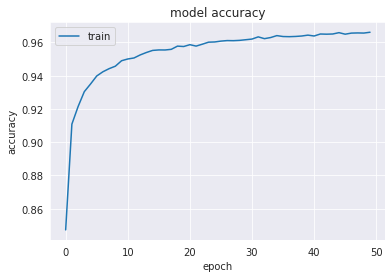

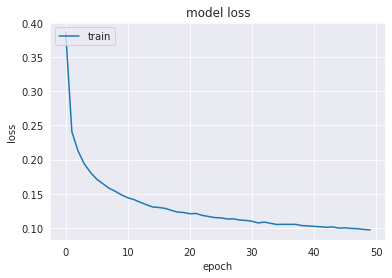

In [29]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
def plot_confusion_matrix(X, y_true):
    classes = ['True','Fake']
    y_pred = model.predict_classes(X)
    con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

    con_mat_df = pd.DataFrame(con_mat_norm,
                        index = classes, 
                        columns = classes)
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


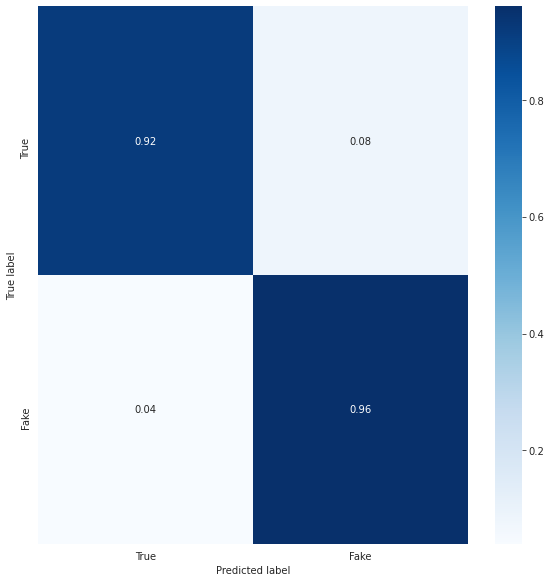

In [31]:
plot_confusion_matrix(testing_padded, testing_labels)

In [46]:
from sklearn.metrics import precision_score , recall_score, f1_score, classification_report   

In [49]:
def precision_recall_f1(X, y_val):    
    y_val_pred=model.predict_classes(X)

    print("\nPrecision score: ",precision_score(y_val,y_val_pred,average=None))
    print("\nRecall score: ",recall_score(y_val,y_val_pred,average=None))
    print("\nF1 score: ",f1_score(y_val,y_val_pred,average=None))
    
    print("\n Classification Report:")
    print(classification_report(y_val, y_val_pred))

In [50]:
precision_recall_f1(testing_padded, testing_labels)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '



Precision score:  [0.96194202 0.92345553]

Recall score:  [0.92303754 0.96215738]

F1 score:  [0.9420883  0.94240928]

 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      5860
           1       0.92      0.96      0.94      5655

    accuracy                           0.94     11515
   macro avg       0.94      0.94      0.94     11515
weighted avg       0.94      0.94      0.94     11515

